- recent update: 24.10.29
- update content:
    1. mid-price 생성
    2. significant or insignificant 예측 모델 생성
    3. significant 예측되는 경우에만 significant increase or decrease인지 예측
- target var: mid price return significant change (0 or 1)
- Model: XGBoost(significant or insignificant 예측) + LSTM(significant increase or decrease 예측)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
#from optuna.integration import XGBoostPruningCallback
#import optuna

In [3]:
import pickle
import torch
from torch.utils.data import DataLoader, Dataset

# .pkl 파일 경로
pkl_file_path = '/content/drive/MyDrive/eunsung/data/sequence_data.pkl'

# 저장된 파일 불러오기
with open(pkl_file_path, 'rb') as file:
    sequence_data = pickle.load(file)

# 로드된 데이터 확인
print(sequence_data.keys())  # ['train_sequences', 'train_labels', 'valid_sequences', 'valid_labels', 'test_sequences', 'test_labels']

# Tensor 데이터 준비
train_sequences = sequence_data['train_sequences']
train_labels = sequence_data['train_labels']
valid_sequences = sequence_data['valid_sequences']
valid_labels = sequence_data['valid_labels']
test_sequences = sequence_data['test_sequences']
test_labels = sequence_data['test_labels']

# Custom Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Dataset 생성
train_dataset = TimeSeriesDataset(train_sequences, train_labels)
valid_dataset = TimeSeriesDataset(valid_sequences, valid_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)

# DataLoader 생성
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# DataLoader 확인
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")
print(f"Test batches: {len(test_loader)}")


dict_keys(['train_sequences', 'train_labels', 'valid_sequences', 'valid_labels', 'test_sequences', 'test_labels'])
Train batches: 8379
Validation batches: 4451
Test batches: 4451


Epoch [1/50], Train Loss: 1.0552, Valid Loss: 1.0788
Epoch [2/50], Train Loss: 1.0688, Valid Loss: 1.1402
Epoch [3/50], Train Loss: 1.1260, Valid Loss: 1.2123
Epoch [4/50], Train Loss: 1.1480, Valid Loss: 1.2717
Epoch [5/50], Train Loss: 1.1518, Valid Loss: 1.3269
Early stopping at epoch 6


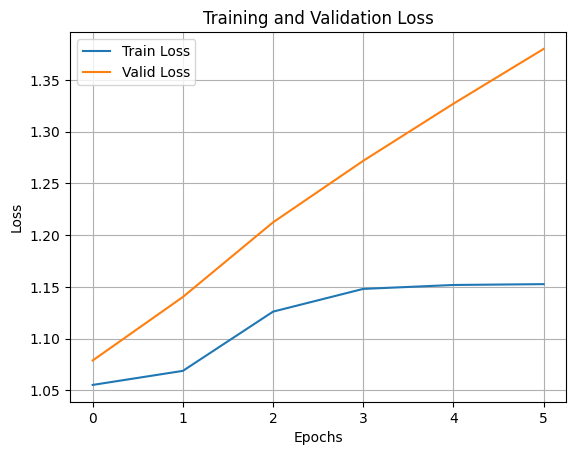

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
hyperparams = {
    "input_dim": 97,
    "num_classes": 3,
    "cnn_filters": [32, 64, 128],  # Filter sizes for each CNN layer
    "cnn_kernel_size": 3,
    "lstm_hidden_dim": 128,
    "num_lstm_layers": 2,
    "dropout_rate": 0.5,
    "batch_size": 64,
    "epochs": 50,
    "learning_rate": 3e-4,
    "weight_decay": 1e-5,
    "gradient_clipping": 1.0,
    "patience": 5,
    "model_save_path": "./model_cnn_lstm_v4"
}

# Create model save directory
os.makedirs(hyperparams["model_save_path"], exist_ok=True)

# 수정된 CNN-LSTM Classifier
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, cnn_filters, cnn_kernel_size, lstm_hidden_dim, num_lstm_layers, dropout_rate):
        super(CNNLSTMClassifier, self).__init__()

        # CNN layers with reduced complexity
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=cnn_filters[0], kernel_size=cnn_kernel_size, padding=cnn_kernel_size // 2),
            nn.BatchNorm1d(cnn_filters[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(dropout_rate),

            nn.Conv1d(in_channels=cnn_filters[0], out_channels=cnn_filters[1], kernel_size=cnn_kernel_size, padding=cnn_kernel_size // 2),
            nn.BatchNorm1d(cnn_filters[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(dropout_rate)
        )

        # LSTM layers with reduced hidden dimensions
        self.lstm = nn.LSTM(
            input_size=cnn_filters[1],
            hidden_size=lstm_hidden_dim // 2,  # Reduced hidden dimensions
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout_rate
        )

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim // 2, lstm_hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(lstm_hidden_dim // 4, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, input_dim, sequence_length)
        x = self.cnn(x)         # Apply CNN
        x = x.permute(0, 2, 1)  # Rearrange back to (batch_size, sequence_length, cnn_features)

        # LSTM
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])  # Use the last hidden state from LSTM

# Training function with weighted CrossEntropy
def train_model(model, train_loader, valid_loader, hyperparams, class_weights=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    best_valid_loss = float('inf')
    patience_counter = 0

    train_losses, valid_losses = [], []

    for epoch in range(hyperparams["epochs"]):
        model.train()
        train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=hyperparams["gradient_clipping"])
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        scheduler.step()  # Adjust learning rate

        # Early Stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{hyperparams['model_save_path']}/best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= hyperparams["patience"]:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        print(f"Epoch [{epoch + 1}/{hyperparams['epochs']}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    return train_losses, valid_losses

# 주요 하이퍼파라미터 조정
hyperparams.update({
    "cnn_filters": [16, 32],  # Further reduced filter sizes
    "dropout_rate": 0.6,      # Increased dropout rate
    "learning_rate": 1e-5,    # Reduced learning rate for stability
})

# Class weights for imbalance handling
class_counts = np.bincount(train_labels)
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32).to(device)

# Initialize and train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMClassifier(
    input_dim=hyperparams["input_dim"],
    num_classes=hyperparams["num_classes"],
    cnn_filters=hyperparams["cnn_filters"],
    cnn_kernel_size=hyperparams["cnn_kernel_size"],
    lstm_hidden_dim=hyperparams["lstm_hidden_dim"],
    num_lstm_layers=hyperparams["num_lstm_layers"],
    dropout_rate=hyperparams["dropout_rate"]
).to(device)

train_losses, valid_losses = train_model(model, train_loader, valid_loader, hyperparams, class_weights=class_weights)

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()


<ipython-input-6-553992f45d01>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(hyperparams["model_save_path"], 'best_model.pth

                        precision    recall  f1-score   support

  Significant Increase       0.27      1.00      0.42     76260
Insignificant Increase       0.00      0.00      0.00    180043
Insignificant Decrease       0.00      0.00      0.00     28561

              accuracy                           0.27    284864
             macro avg       0.09      0.33      0.14    284864
          weighted avg       0.07      0.27      0.11    284864



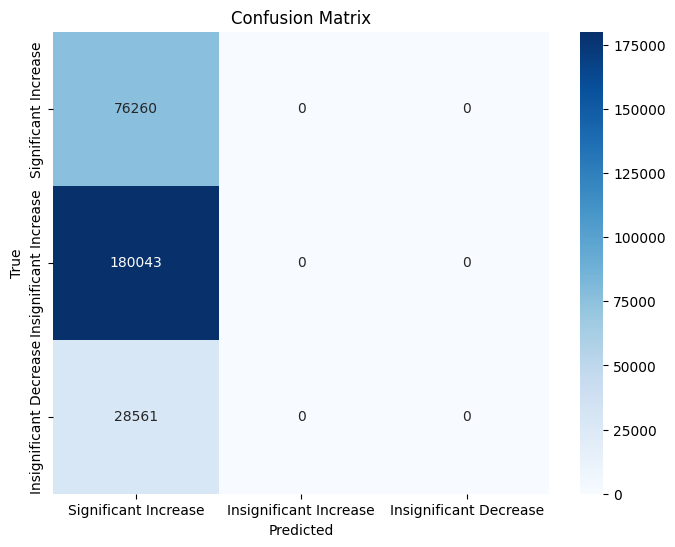

In [6]:
# # Evaluation on Test Set
# model.load_state_dict(torch.load(os.path.join(hyperparams["model_save_path"], 'best_model.pth')))
# model.eval()

# Load the best model and test
model.load_state_dict(torch.load(os.path.join(hyperparams["model_save_path"], 'best_model.pth')))
model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Classification Report and Confusion Matrix
print(classification_report(all_targets, all_preds, target_names=["Significant Increase", "Insignificant Increase", "Insignificant Decrease"]))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Significant Increase", "Insignificant Increase", "Insignificant Decrease"], yticklabels=["Significant Increase", "Insignificant Increase", "Insignificant Decrease"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### 실제 데이터에 적용
- insignificant increase, decrease도 적용

- Precision (정밀도):

정밀도는 모델이 해당 클래스로 예측한 값 중 실제로 맞은 비율입니다.
예를 들어, "Significant increase" 클래스에 대해 모델이 98%의 정밀도를 보였다는 것은, 모델이 이 클래스로 예측한 값 중 98%가 실제로 맞았다는 의미입니다.
하지만 "Significant decrease" 클래스는 데이터에 등장하지 않아서 정밀도가 0.00으로 표시되었습니다.

- Recall (재현율):

재현율은 실제로 해당 클래스에 속한 데이터 중에서 모델이 올바르게 예측한 비율입니다.
예를 들어, "Insignificant increase" 클래스에 대한 재현율이 0.92라는 것은, 실제로 "Insignificant increase"에 속한 데이터 중 92%를 모델이 정확히 맞췄다는 의미입니다.
"Significant increase" 클래스의 재현율이 0.01이라는 것은, 이 클래스에 속한 실제 데이터 중 1%만 모델이 맞췄다는 의미입니다.

- F1-score:

F1 스코어는 정밀도와 재현율의 조화평균으로, 두 지표를 종합적으로 평가하는 지표입니다. 정밀도와 재현율 사이의 균형을 중요시할 때 유용합니다.
예를 들어, "Insignificant increase" 클래스의 F1 스코어가 0.84라는 것은, 정밀도와 재현율이 적절히 균형을 이뤘음을 의미합니다.

- Support:

Support는 각 클래스에 실제로 속한 데이터의 개수입니다.
예를 들어, "Insignificant increase" 클래스는 241,234개의 데이터 포인트를 가지고 있다는 것을 의미합니다.

- Micro avg (마이크로 평균):

마이크로 평균은 전체 데이터에서의 정밀도, 재현율, F1 스코어를 계산합니다. 이는 각 클래스의 데이터 개수를 고려하지 않고, 전체 데이터를 한 번에 평가하는 방식입니다.
마이크로 평균 77%는 모든 클래스의 데이터를 합쳐서 모델이 77%의 정확도를 보였음을 의미합니다.

- Macro avg (매크로 평균):

매크로 평균은 각 클래스의 정밀도, 재현율, F1 스코어의 평균을 단순히 계산한 것입니다. 이는 클래스별 데이터 비율을 고려하지 않기 때문에, 클래스 간 불균형이 있는 경우 잘못된 평가가 나올 수 있습니다.
예를 들어, "Significant decrease" 클래스처럼 데이터가 없는 클래스는 성능이 0으로 평가되며, 이러한 클래스들도 평균에 포함되기 때문에 성능이 낮아집니다.

- Weighted avg (가중 평균):

가중 평균은 각 클래스의 정밀도, 재현율, F1 스코어를 해당 클래스의 데이터 개수에 비례하여 평균을 계산한 것입니다. 즉, 클래스의 데이터가 많을수록 해당 클래스의 성능이 평균에 더 큰 영향을 줍니다.
Weighted 평균 77%는 실제 데이터 비율에 따라 가중치를 부여하여 계산한 성능입니다. 이 값은 전체적으로 모델이 77%의 정확도를 가지고 있음을 보여줍니다.